In [1]:
# tolgo i warning dalle print
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importo il dataset grezzo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

df_raw = pd.read_csv("UNIPI-IA-dataset.csv")

In [8]:
# definiamo i tipi in uno specifico ordine. Questo serve perché in caso di duplicati, per esempio:
# https://www.sito-strano.com/haivintounpremio - malware
# https://www.sito-strano.com/haivintounpremio - benign
#
# rimuoveremmo tutti i sample, tranne il primo. Si è deciso questo perché, in questo contesto,
# è preferibile avere un Falso Positivo (FP), manualmente "correggibile" dall'utente, che un Falso Negativo (FN),
# che potrebbe esporrebbe l'utente ad un sito malevolo.

types = ["malware", "phishing", "defacement", "benign"]

df_raw["type"] = pd.Categorical(df_raw["type"], categories=types, ordered=True)
df = df_raw.sort_values(by="type").drop_duplicates(subset="url", keep="first")

print(f"Sample nel Dataset originale: {df_raw.shape[0]}\nSample nel Dataset senza duplicati: {df.shape[0]} (riduzione del {((df_raw.shape[0] - df.shape[0]) / df_raw.shape[0]) * 100:.2f}%)")
print("Distribuzione delle classi nel dataset:")
for type_name in types:
    count = df[df['type'] == type_name].shape[0]
    percentage = (count / df.shape[0]) * 100
    print(f"{type_name}: {count} samples ({percentage:.2f}%)")

Sample nel Dataset originale: 651191
Sample nel Dataset senza duplicati: 641119 (riduzione del 1.55%)
Distribuzione delle classi nel dataset:
malware: 23645 samples (3.69%)
phishing: 94092 samples (14.68%)
defacement: 95308 samples (14.87%)
benign: 428074 samples (66.77%)


In [4]:
# estriamo 23 feature
from utils.features_extractors import (extract_feature_ip_use,extract_feature_url_entropy,extract_feature_num_digits,extract_feature_url_length,extract_feature_num_query_parameters,extract_feature_num_fragments,extract_feature_num_percent20,extract_feature_num_at_signs,extract_feature_has_http,extract_feature_has_https,extract_feature_dot_number,extract_feature_num_www, extract_feature_directory_num,extract_feature_embed_domain_number,extract_feature_suspiciousurl,extract_feature_count_percent,extract_feature_count_dash,extract_feature_count_equal,extract_feature_is_shortened,extract_feature_hostname_length,extract_feature_first_directory_length,extract_feature_top_level_domain_length,extract_feature_num_letters)

df['ip_use'] = df['url'].apply(extract_feature_ip_use)
df['url_entropy'] = df['url'].apply(extract_feature_url_entropy)
df['num_digits'] = df['url'].apply(extract_feature_num_digits)
df['url_length'] = df['url'].apply(extract_feature_url_length)
df['num_query_parameters'] = df['url'].apply(extract_feature_num_query_parameters)
df['num_fragments'] = df['url'].apply(extract_feature_num_fragments)
df['num_percent20'] = df['url'].apply(extract_feature_num_percent20)
df['num_at_signs'] = df['url'].apply(extract_feature_num_at_signs)
df['has_http'] = df['url'].apply(extract_feature_has_http)
df['has_https'] = df['url'].apply(extract_feature_has_https)
df['dot_number'] = df['url'].apply(extract_feature_dot_number)
df['num_www'] = df['url'].apply(extract_feature_num_www)
df['directory_num'] = df['url'].apply(extract_feature_directory_num)
df['embed_domain_number'] = df['url'].apply(extract_feature_embed_domain_number)
df['suspiciousurl'] = df['url'].apply(extract_feature_suspiciousurl)
df['count_percent'] = df['url'].apply(extract_feature_count_percent)
df['count_dash'] = df['url'].apply(extract_feature_count_dash)
df['count_equal'] = df['url'].apply(extract_feature_count_equal)
df['is_shortened'] = df['url'].apply(extract_feature_is_shortened)
df['hostname_length'] = df['url'].apply(extract_feature_hostname_length)
df['first_directory_length'] = df['url'].apply(extract_feature_first_directory_length)
df['top_level_domain_length'] = df['url'].apply(extract_feature_top_level_domain_length)
df['num_letters'] = df['url'].apply(extract_feature_num_letters)

print(f"Numero di feature totale: { df.drop(columns=['type', 'url']).shape[1] }")

Numero di feature totale: 23


In [5]:

df = df.drop(columns=["embed_domain_number", "count_equal", "url_length", "first_directory_length"])

In [6]:


#colonne binarie
binary_features = ['ip_use', 'has_http', 'has_https', 'suspiciousurl', 'is_shortened']

# Selezioniamo le colonne numeriche (escludendo le binarie)
numeric_features = [col for col in df.columns if col not in binary_features + ['type', 'url']]

# Standardizza solo le colonne numeriche
scaler = StandardScaler()
y = df['type']
df_scaled = df.copy()  # Fai una copia di df per non modificare l'originale
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])  # Standardizza le numeriche

# df_scaled ora contiene le colonne numeriche standardizzate e le binarie invariabili

X = df_scaled.drop(columns=['type', 'url'])  # Rimuovo le colonne non numeriche

# Estrai un campione casuale dal DataFrame
X_sampled = X#.sample(n=60000, random_state=42)
y_sampled = y[X_sampled.index]

In [ ]:
import numpy as np
from pyclustertend import hopkins
from tqdm import tqdm

# Convert DataFrame to numpy array for hopkins statistic
X_sampled_array = X_sampled.to_numpy()
sampling_size = int(0.1 * len(X_sampled_array))

# Calculate single Hopkins Score
hopkins_score = hopkins(X_sampled_array, sampling_size)

print(f"Hopkins Statistic: {hopkins_score:.3f}")
print("\nInterpretazione:")
print("- Valore vicino a 1: forte tendenza al clustering")
print("- Valore vicino a 0.5: distribuzione casuale uniforme") 
print("- Valore vicino a 0: distribuzione regolare")

# Multiple trials with standard progress bar
n_trials = 10
hopkins_scores = []

print("\nCalcolando multiple Hopkins Statistics...")
for _ in tqdm(range(n_trials)):
    hopkins_scores.append(hopkins(X_sampled_array, sampling_size))

avg_hopkins = np.mean(hopkins_scores)
std_hopkins = np.std(hopkins_scores)

print(f"\nHopkins Statistic (media di {n_trials} prove): {avg_hopkins:.3f} ± {std_hopkins:.3f}")


Hopkins Statistic: 0.001

Interpretazione:
- Valore vicino a 1: forte tendenza al clustering
- Valore vicino a 0.5: distribuzione casuale uniforme
- Valore vicino a 0: distribuzione regolare

Calcolando multiple Hopkins Statistics...


100%|██████████| 10/10 [51:02<00:00, 306.29s/it]


Hopkins Statistic (media di 10 prove): 0.001 ± 0.000


: 

Lo lascio per la presentazione..

Applichiamo ora il DBSCAN, scegliendo come min_pts=2*n=38, dove n è il nostro numero di features

In [ ]:
# Apply DBSCAN clustering

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
dbscan = DBSCAN(eps=1, min_samples=76,n_jobs=-1)
clusters = dbscan.fit_predict(X_sampled)

# Get unique clusters and their counts
unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)

# Print clustering results
print("Number of clusters found:", len(unique_clusters) - 1)  # -1 to exclude noise points

print("\nCluster distribution:")
for cluster, count in zip(unique_clusters, cluster_counts):
    if cluster == -1:
        print(f"Noise points: {count}")
    else:
        print(f"Cluster {cluster}: {count}")

# Calculate percentage of outliers
outliers = X_sampled[clusters == -1]
outlier_percentage = (len(outliers) / len(X)) * 100
print(f"\nPercentage of outliers: {outlier_percentage:.2f}%")




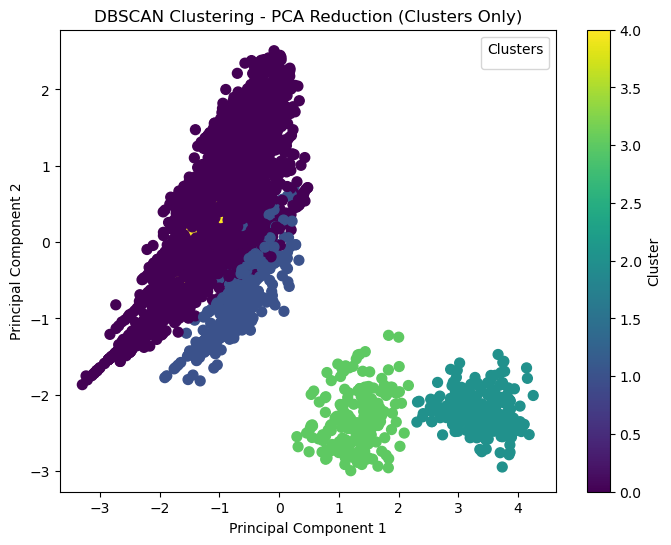

In [9]:
pca = PCA(n_components=2)
X_sampled_pca = pca.fit_transform(X_sampled)

# Filtra solo i punti che appartengono ai cluster (non outliers)
clustered_points = X_sampled_pca[clusters != -1]
cluster_labels = clusters[clusters != -1]

plt.figure(figsize=(8, 6))

# Visualizza solo i punti appartenenti ai cluster
scatter = plt.scatter(clustered_points[:, 0], clustered_points[:, 1], c=cluster_labels, cmap='viridis', s=50)

# Aggiungi una legenda e etichette
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.title('DBSCAN Clustering - PCA Reduction (Clusters Only)')
plt.colorbar(scatter, label='Cluster')

plt.show()


Data l'assenza di cluster, i risultati di un LOF non sarebbero attendibili. Decidiamo di usare l'isolation forest

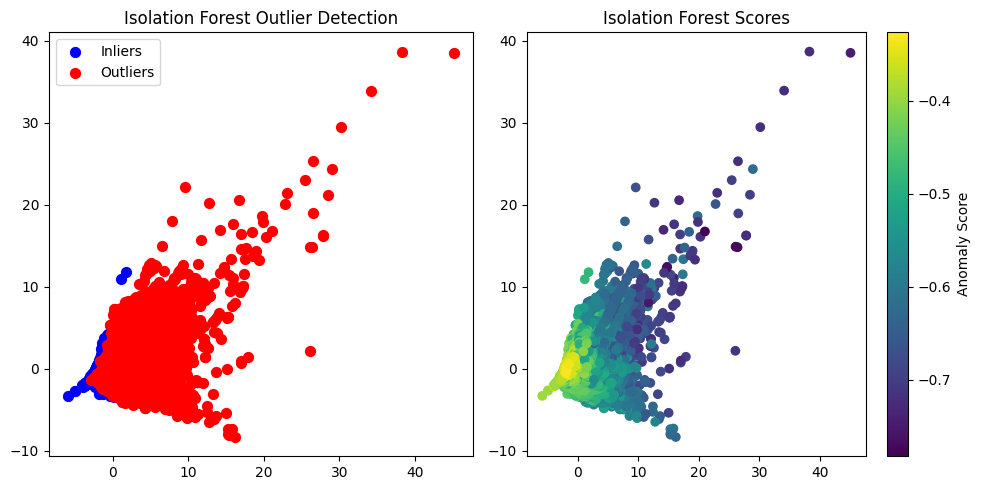

Percentage of outliers identified: 12.42%

Distribution of outliers by class:
type
benign        30404
defacement    18758
malware       16194
phishing      14272
Name: count, dtype: int64


In [10]:
from sklearn.ensemble import IsolationForest

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
y_pred_if = iso_forest.fit_predict(X_sampled)

# Convert predictions to outlier mask (True for outliers)
outliers_mask_if = y_pred_if == -1

# Calculate percentage of outliers
outlier_percentage_if = (outliers_mask_if.sum() / len(X_sampled)) * 100

# Visualize results with PCA
plt.figure(figsize=(10, 5))

# Plot 1: Visualize inliers and outliers
plt.subplot(121)
plt.scatter(X_sampled_pca[~outliers_mask_if, 0], X_sampled_pca[~outliers_mask_if, 1], 
           c='blue', s=50, label='Inliers')
plt.scatter(X_sampled_pca[outliers_mask_if, 0], X_sampled_pca[outliers_mask_if, 1], 
           c='red', s=50, label='Outliers')
plt.title('Isolation Forest Outlier Detection')
plt.legend()

# Plot 2: Visualize decision scores
scores_if = iso_forest.score_samples(X_sampled)
plt.subplot(122)
plt.scatter(X_sampled_pca[:, 0], X_sampled_pca[:, 1], 
           c=scores_if, cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.title('Isolation Forest Scores')

plt.tight_layout()
plt.show()

print(f"Percentage of outliers identified: {outlier_percentage_if:.2f}%")

# Analysis of outliers by class
y_outliers_if = y_sampled[outliers_mask_if]
print("\nDistribution of outliers by class:")
print(y_outliers_if.value_counts())

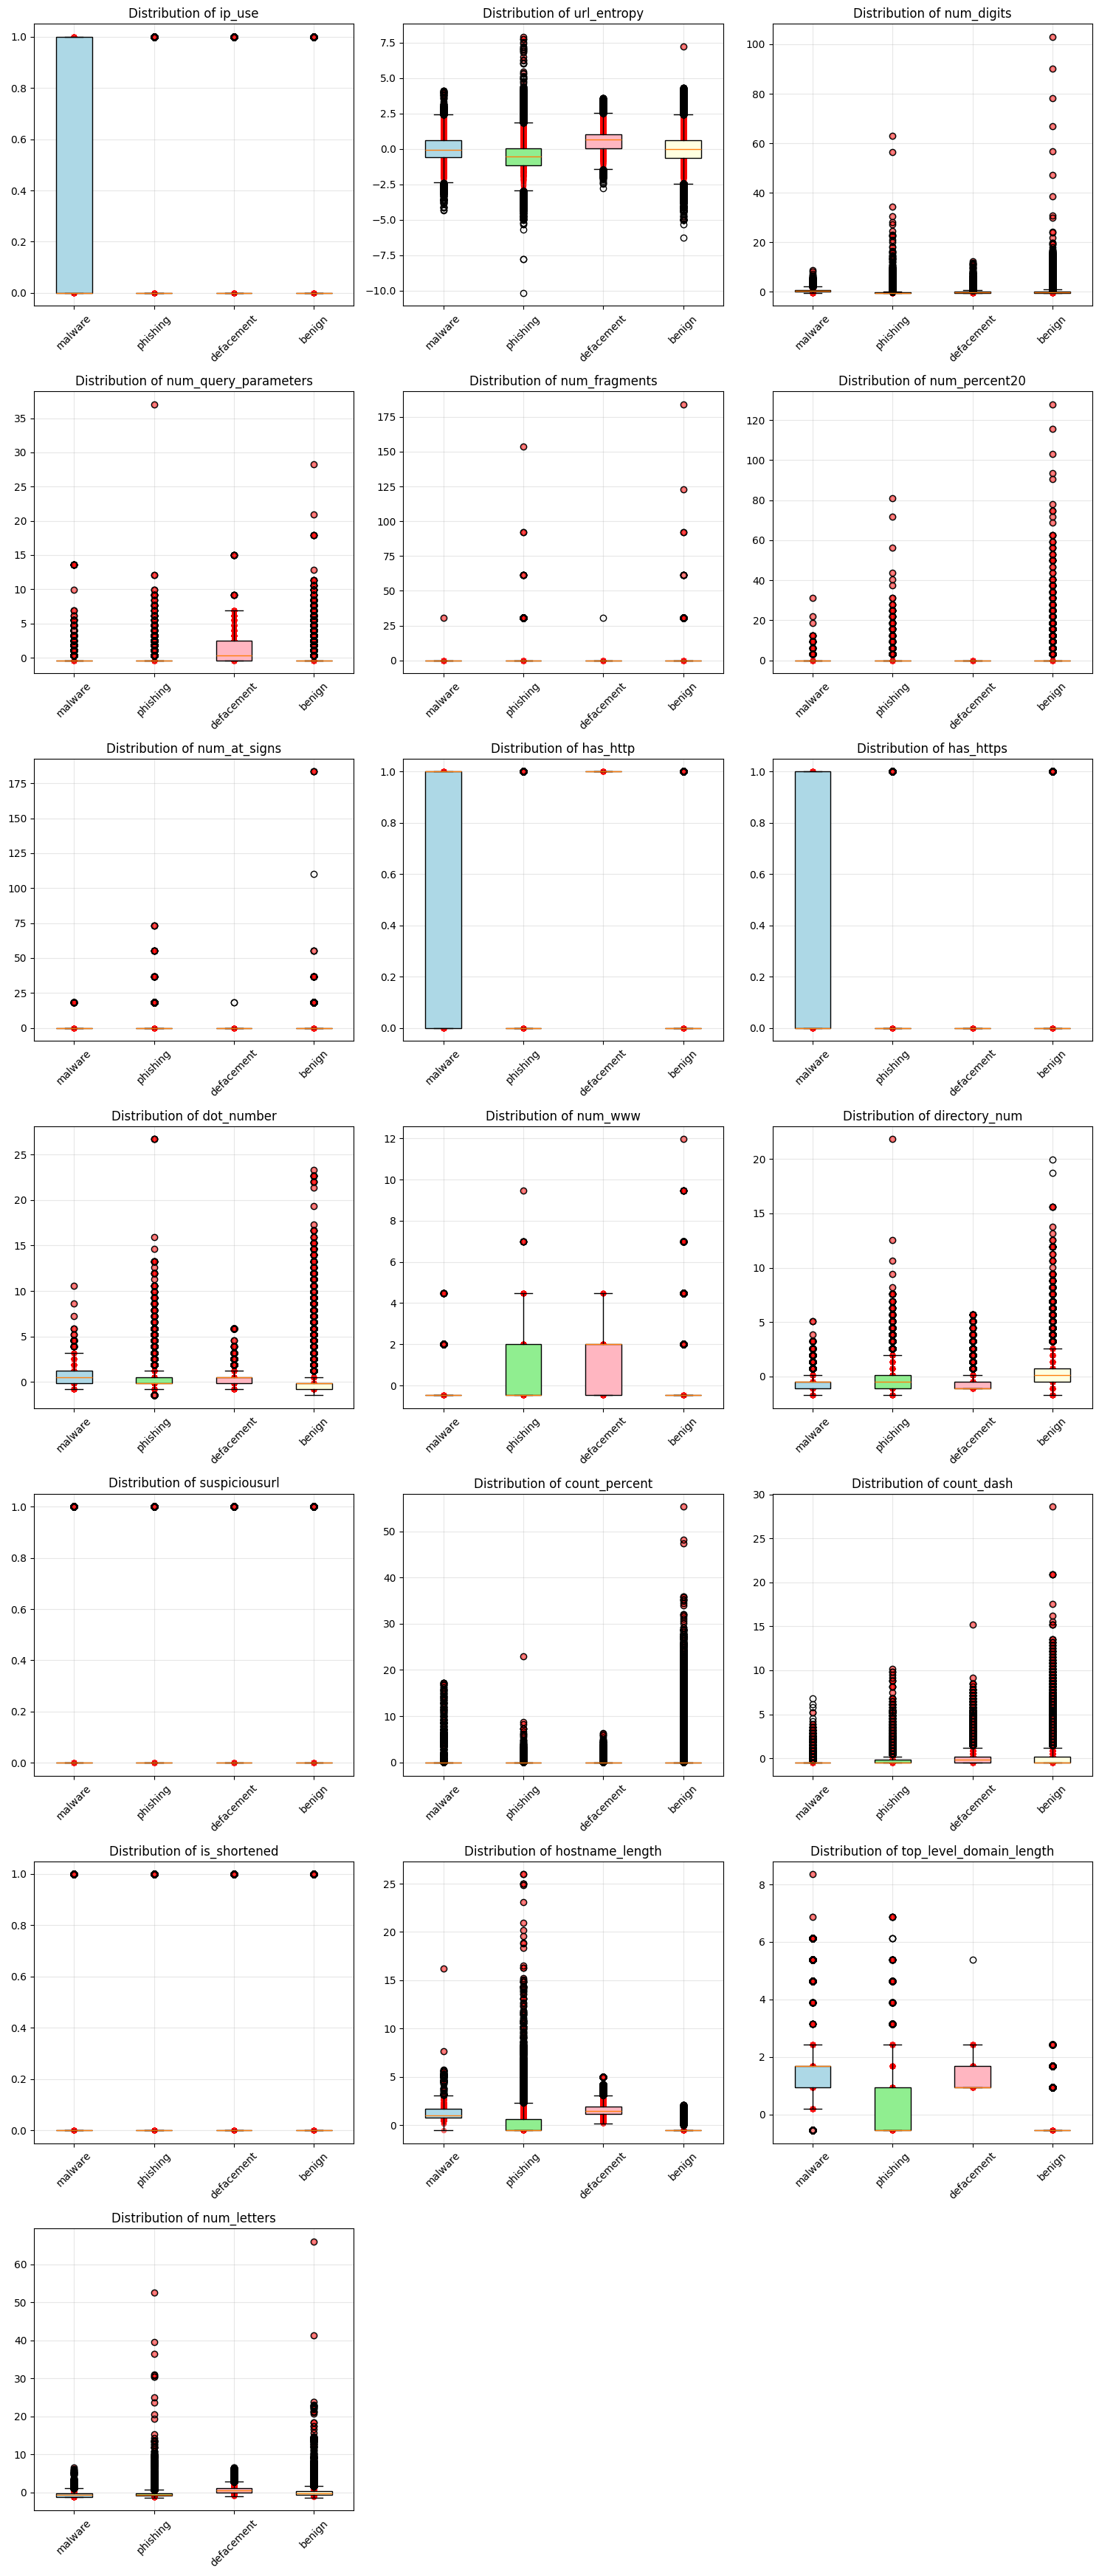


Feature statistics for outliers vs non-outliers:

ip_use:
Outlier mean: 0.244
Non-outlier mean: 0.001

url_entropy:
Outlier mean: 0.861
Non-outlier mean: -0.122

num_digits:
Outlier mean: 1.227
Non-outlier mean: -0.174

num_query_parameters:
Outlier mean: 0.802
Non-outlier mean: -0.114

num_fragments:
Outlier mean: 0.080
Non-outlier mean: -0.011

num_percent20:
Outlier mean: 0.309
Non-outlier mean: -0.044

num_at_signs:
Outlier mean: 0.169
Non-outlier mean: -0.024

has_http:
Outlier mean: 0.633
Non-outlier mean: 0.199

has_https:
Outlier mean: 0.143
Non-outlier mean: 0.008

dot_number:
Outlier mean: 0.998
Non-outlier mean: -0.142

num_www:
Outlier mean: 0.359
Non-outlier mean: -0.051

directory_num:
Outlier mean: -0.011
Non-outlier mean: 0.002

suspiciousurl:
Outlier mean: 0.334
Non-outlier mean: 0.060

count_percent:
Outlier mean: 0.603
Non-outlier mean: -0.085

count_dash:
Outlier mean: 0.253
Non-outlier mean: -0.036

is_shortened:
Outlier mean: 0.109
Non-outlier mean: 0.046

hostna

In [12]:
# Create subplots for all features
n_features = X_sampled.shape[1]
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5*n_rows))

# For each feature
for i, feature in enumerate(X_sampled.columns):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Create boxplot data for each class
    box_data = [X_sampled[y_sampled == class_type][feature] for class_type in types]
    
    # Create boxplot
    bp = plt.boxplot(box_data, labels=types, patch_artist=True)
    
    # Color boxes based on class
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Overlay outlier points in red for points identified by Isolation Forest
    for j, class_type in enumerate(types):
        mask = (y_sampled == class_type) & outliers_mask_if
        if mask.any():
            plt.scatter([j + 1] * mask.sum(), X_sampled[mask][feature], 
                       color='red', alpha=0.5, s=20)
    
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for outliers vs non-outliers
print("\nFeature statistics for outliers vs non-outliers:")
for feature in X_sampled.columns:
    outlier_mean = X_sampled[outliers_mask_if][feature].mean()
    non_outlier_mean = X_sampled[~outliers_mask_if][feature].mean()
    print(f"\n{feature}:")
    print(f"Outlier mean: {outlier_mean:.3f}")
    print(f"Non-outlier mean: {non_outlier_mean:.3f}")